### **Prétraitement des Données :**

#### **1. Identification et Traitement des Valeurs Manquantes :**

Dans notre dataset, les colonnes : ``Glucose``, ``BloodPressure``, ``SkinThickness``, ``Insulin``, ``BMI`` contiennent des zéros qui ne sont pas des vraies valeurs, mais des valeurs manquantes (parce qu’un patient ne peut pas avoir un glucose ou un BMI = 0).

**Pourquoi ces zéros sont considérés comme manquants ?**

Dans notre dataset :

- ``0`` a été mis à la place des valeurs non mesurées.

- Ces zéros faussent les statistiques (moyenne, écart-type, corrélation…).

- Si on ne les traite pas, notre modèle par la suite va croire que ``0`` est une vraie valeur physiologique, ce qui peut détourner complètement les clusters.

##### **1.1. Remplaçement des Zéros avec NaN :**



In [29]:
import pandas as pd
import numpy as np

data = pd.read_csv("../data/raw/data.csv")

columns = data.columns.to_list()

delete = columns.pop(0)

data_copy = pd.DataFrame(data, columns=columns)

cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

data_copy[cols_with_zeros] = data_copy[cols_with_zeros].replace(0, np.nan)

data_copy.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


##### **1.2. Imputation avec KNN Imputer :**

Le ``KNN Imputer`` (``K-Nearest Neighbors Imputer``) est une méthode d’imputation des valeurs manquantes basée sur l’algorithme des K plus proches voisins (``KNN``).

Son rôle est de remplacer les valeurs manquantes dans un jeu de données par des valeurs estimées à partir des observations les plus similaires (les voisins).

**Comment ça fonctionne ?**

1. Pour chaque observation contenant une ou plusieurs valeurs manquantes : On cherche les ``K observations`` les plus proches (en termes de distance).

2. Pour trouver cette similarité, le ``KNN Imputer`` calcule la distance (souvent ``euclidienne``) entre les lignes en ignorant les colonnes manquantes.

3. Ensuite, pour chaque valeur manquante : Il remplace la valeur manquante par la ``moyenne`` (ou ``médiane``) des valeurs correspondantes trouvées chez les ``K`` voisins.

**la distance Euclidienne :**

si on a deux points A et B dans un espace à 2 dimensions : $A(x_1, y_1)$ et $B(x_2, y_2)$

Alors la distance euclidienne $d(A,B)$ est :

$$d(A,B) = \sqrt{(x_1 - x_2)² + (y_1 - y_2)²}$$

In [30]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

data_copy[cols_with_zeros] = imputer.fit_transform(data_copy[cols_with_zeros])

data = data_copy

print(data.isnull().sum().sum())

data.head()

0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,209.0,33.6,0.627,50
1,1,85.0,66.0,29.0,73.0,26.6,0.351,31
2,8,183.0,64.0,29.4,383.2,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


#### **2. Détection des Outliers :**

##### **2.1. Boxplots :**

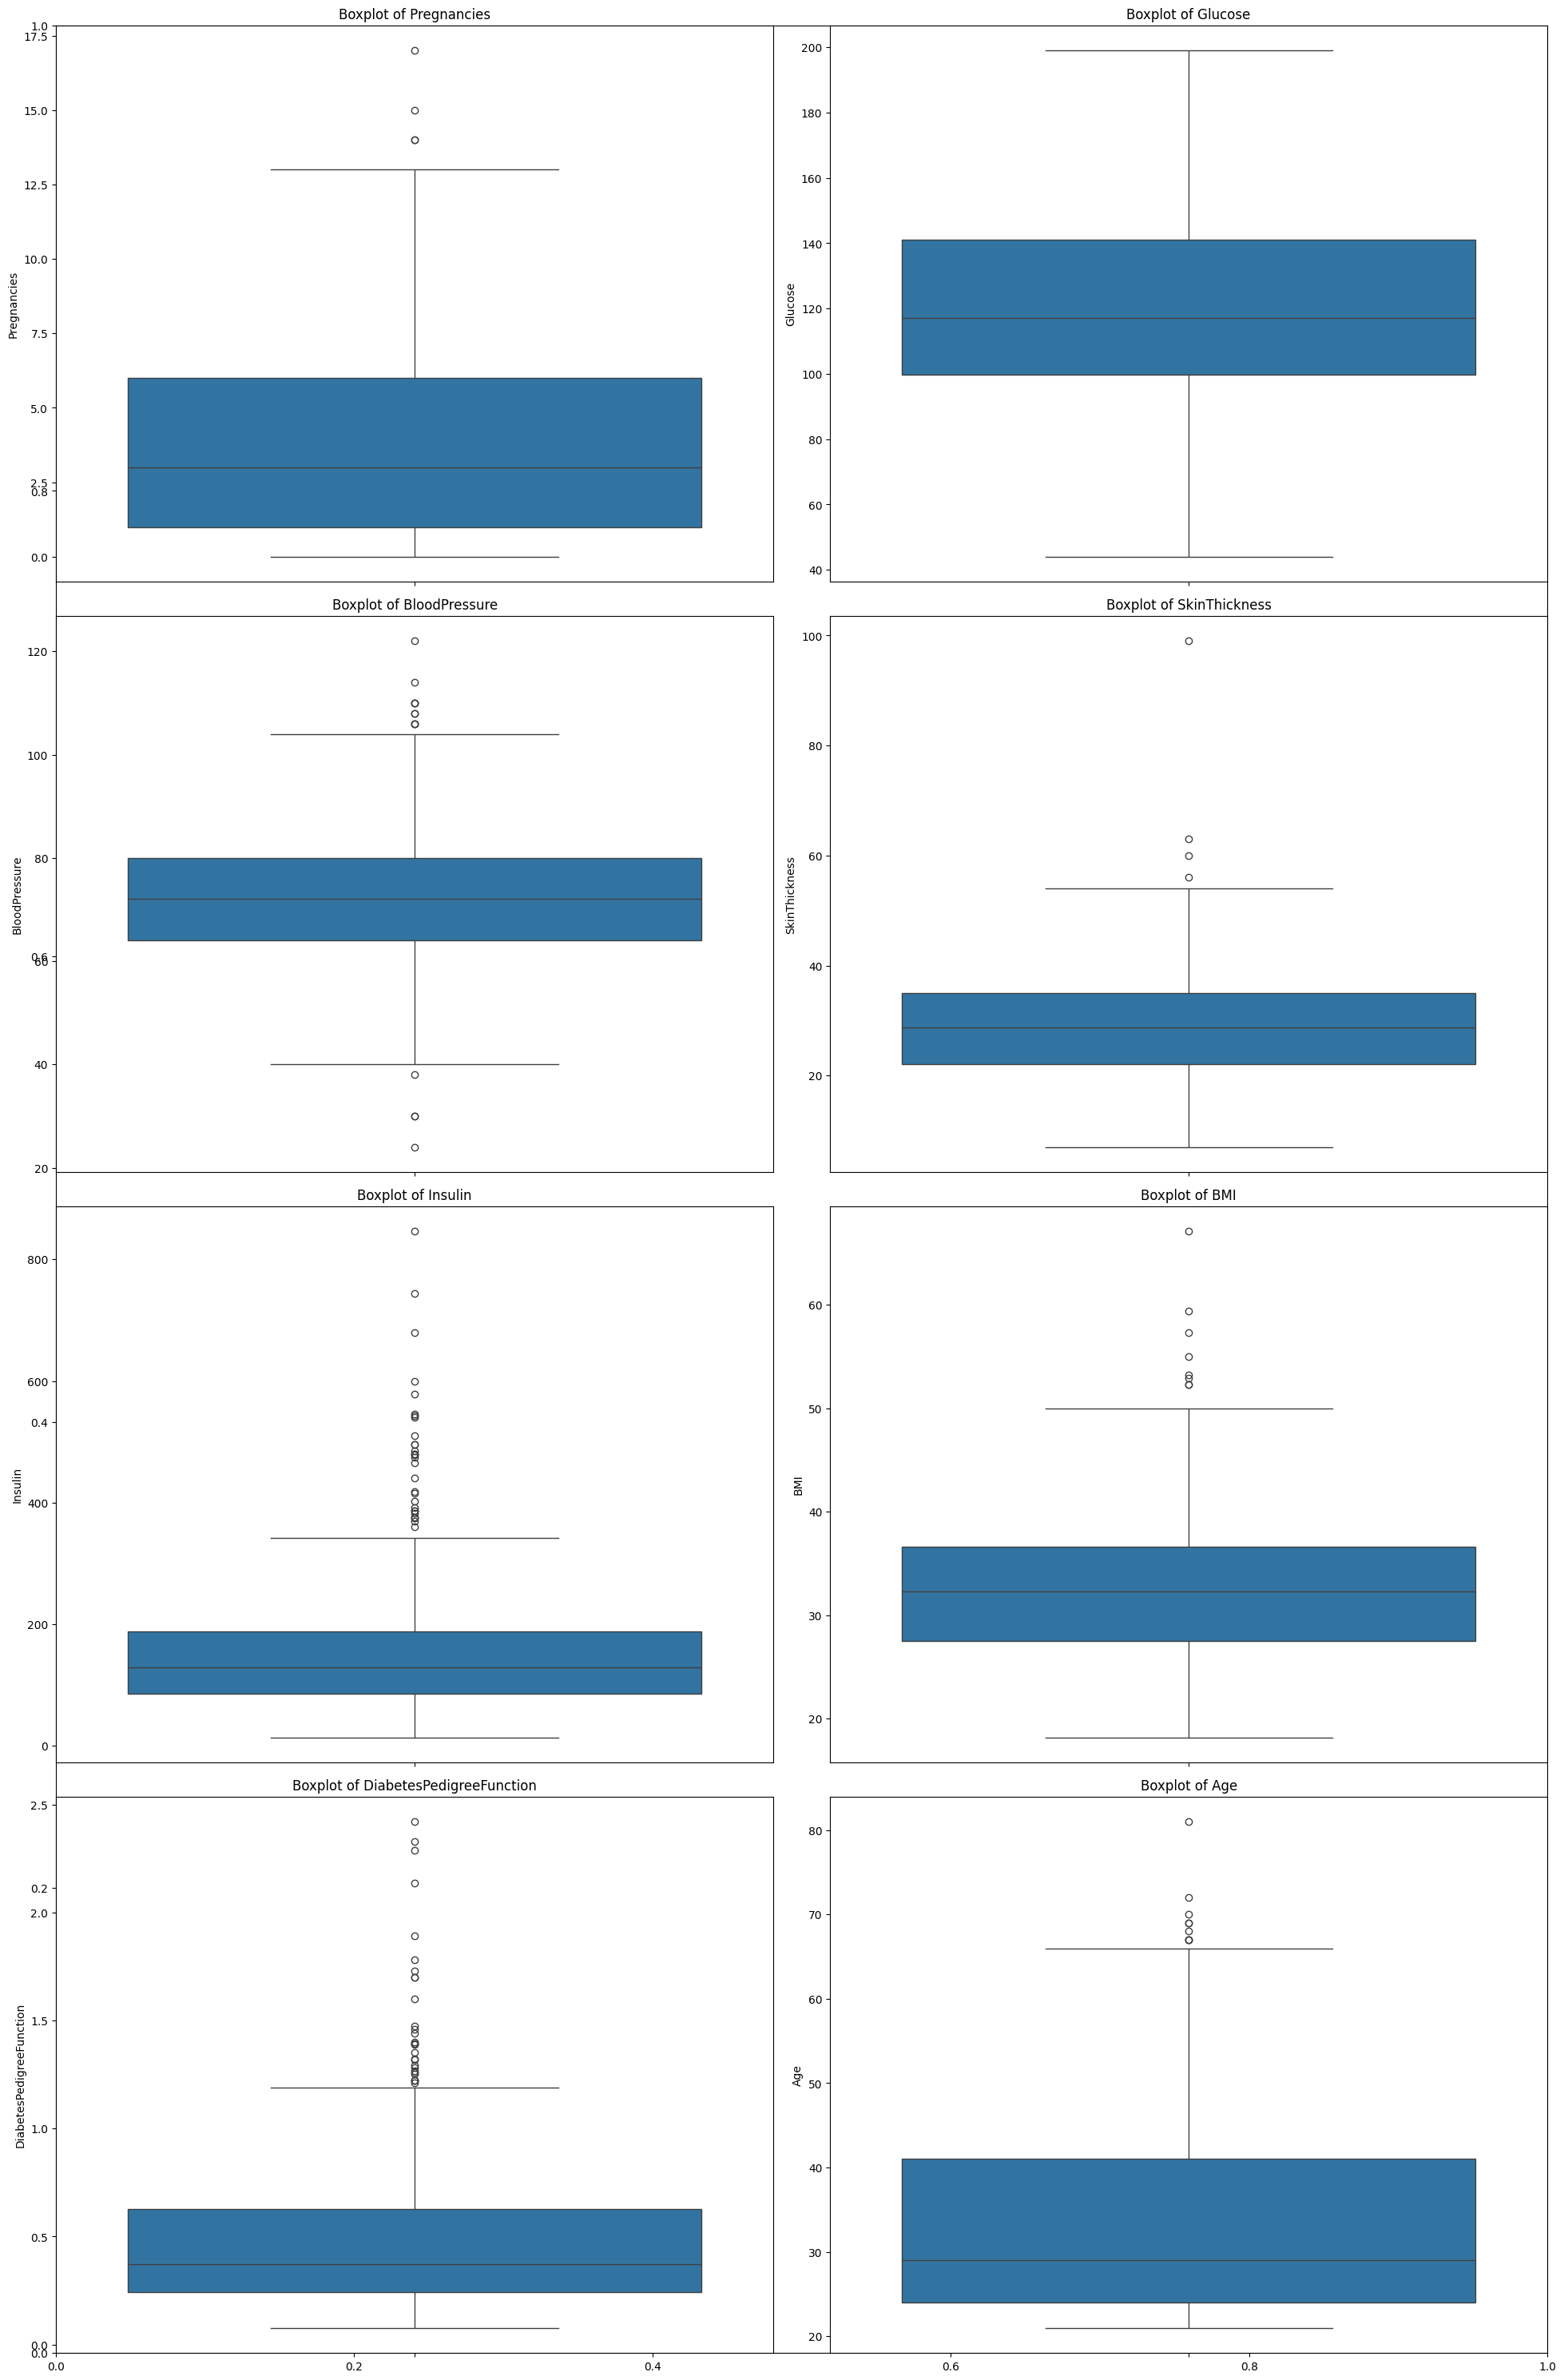

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize = (20, 30))

features = data.columns.to_list()

for i, col in enumerate(features) :
    plt.subplot(4, 2, i + 1)
    sns.boxplot(y=data[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show()


**Analyse et Observation :**

| Variable| Médiane (approx.) | Dispersion (IQR approx.) |  Observation|
| :-----:| :----------------: | :----------------------: | :---------: |
| Pregnancies | 3 | 1 - 6 |  Quelques valeurs aberrantes élevées. |
| Glucose | 117 | 100 - 140 |  L'abscence des valeurs aberrantes. |
| BloodPressure | 72 | 65 - 80 |  Valeurs aberrantes basses et élevées.|
| SkinThickness | 23 | 21 - 37 |  Nombreuses valeurs à 0 qui faussent la distribution (données manquantes). |
| Insulin | 30 | 100 - 200 |  Grand nombre de valeurs aberrantes élevées. Les valeurs à 0 sont suspectes. |
| BMI | 32 | 28 - 37 |  Une valeur aberrante à 0 (donnée erronée) et plusieurs valeurs élevées. |
| DiabetesPedigreeFunction | 0.37 | 0.25 - 0.65 |  Nombreuses valeurs aberrantes élevées. |
| Age | 29 | 24 - 41 |  Plusieurs valeurs aberrantes élevées (personnes plus âgées). |


##### **2.2. IQR :**


In [40]:
outliers_cols = []

for col in data.columns.to_list() :
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)

    IQR = Q3 - Q1

    borne_max = Q3 + 1.5 * IQR
    borne_min = Q1 - 1.5 * IQR

    outliers = data[(data[col] > borne_max) | (data[col] < borne_min)]

    if outliers.empty :
        print(f"La colonne {col} ne contient pas des Outliers !")
    else :
        outliers_cols.append(col)
        print(f"La colonne {col} contient des Outliers :")
        print(outliers.count())
    
    print("\n-------------------------------------------------------------------\n")

La colonne Pregnancies contient des Outliers :
Pregnancies                 4
Glucose                     4
BloodPressure               4
SkinThickness               4
Insulin                     4
BMI                         4
DiabetesPedigreeFunction    4
Age                         4
dtype: int64

-------------------------------------------------------------------

La colonne Glucose ne contient pas des Outliers !

-------------------------------------------------------------------

La colonne BloodPressure contient des Outliers :
Pregnancies                 14
Glucose                     14
BloodPressure               14
SkinThickness               14
Insulin                     14
BMI                         14
DiabetesPedigreeFunction    14
Age                         14
dtype: int64

-------------------------------------------------------------------

La colonne SkinThickness contient des Outliers :
Pregnancies                 4
Glucose                     4
BloodPressure        

**Analyse et Comparaison :**

| Variable | Analyse Visuelle (Boxplot) | Résultat du Calcul (Script IQR) | Cohérence & Conclusion |
| :--- | :--- | :--- | :--- |
| Pregnancies | Quelques points (valeurs aberrantes) sont visibles au-dessus de la moustache supérieure. | 4 outliers détectés. |  Parfaitement cohérent. Les 4 points vus sur le graphique correspondent aux 4 outliers calculés. |
| Glucose | Pas de points visibles  | "Ne contient pas des Outliers !" |  Parfaitement cohérent |
| BloodPressure | Plusieurs points sont visibles en dessous et au-dessus des moustaches. | 14 outliers détectés. |  Parfaitement cohérent. Le calcul confirme le grand nombre de valeurs extrêmes vues sur le graphique. |
| SkinThickness | Plusieurs points sont visibles au-dessus de la moustache (même s'ils sont proches). | 4 outliers détectés. |  Parfaitement cohérent. Le calcul est plus précis que l'œil et quantifie les points vus. |
| Insulin | Un très grand nombre de points sont visibles au-dessus de la moustache. | 30 outliers détectés. |  Parfaitement cohérent. Le graphique et le calcul montrent une forte présence de valeurs extrêmes. |
| BMI | Plusieurs points sont visibles au-dessus de la moustache, ainsi qu'un point à 0. | 8 outliers détectés. |  Parfaitement cohérent. Le calcul confirme les valeurs extrêmes vues visuellement. |
| DiabetesPedigreeFunction | Un grand nombre de points sont visibles au-dessus de la moustache. | 29 outliers détectés. |  Parfaitement cohérent. Les deux méthodes confirment de nombreuses valeurs aberrantes. |
| Age | Plusieurs points sont visibles au-dessus de la moustache supérieure. | 9 outliers détectés. |  Parfaitement cohérent. Le calcul quantifie précisément ce que le graphique montre. |

<br>